# 1. Setup Mario

In [1]:
!pip install gym_super_mario_bros==7.4.0 nes_py

Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
# Setup game
# Super Mario Bros 2 Version 1
env = gym_super_mario_bros.make('SuperMarioBros-v2' , apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

C:\Users\MUSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v2 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\MUSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [3]:
# Create a flag - restart or not
# Set a flag to indicate if the game is over
done = True
for step in range(100000):
# Start the game to begin with
    if done:
        env.reset()
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated
    env.render()
env.close()

C:\Users\MUSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\MUSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


KeyboardInterrupt: 

In [4]:
# close the python session manually
env.close()

# 2. Preprocess Environment

In [ ]:
#Install Jinja2 3.1.2 
!pip install https://download.pytorch.org/whl/Jinja2-3.1.2-py3-none-any.whl

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/133.1 kB ? eta -:--:--
     ------------------ -------------------- 61.4/133.1 kB 1.6 MB/s eta 0:00:01
     ----------------------------------- -- 122.9/133.1 kB 1.8 MB/s eta 0:00:01
     ------------------------------------ 133.1/133.1 kB 982.9 kB/s eta 0:00:00
  Using cached MarkupSafe-2.1.5-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
Using cached MarkupSafe-2.1.5-cp312-cp312-win_amd64.whl (17 kB)


In [ ]:
# Install pytorch ,Go to pytorch.org and select:
# 1) Pytorch BUILD: STABLE
# 2) Your OS: Windows
# 3) Package: Pip
# 4) Language: Python
# 5) Compute Platform: (Select CUDA if you have a good GPU, otherwise CPU)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 GB 2.6 MB/s eta 0:17:37
     ---------------------------------------- 0.0/2.7 GB 1.5 MB/s eta 0:29:34
     ---------------------------------------- 0.0/2.7 GB 2.1 MB/s eta 0:21:24
     ---------------------------------------- 0.0/2.7 GB 2.3 MB/s eta 0:19:42
     ---------------------------------------- 0.0/2.7 GB 2.5 MB/s eta 0:17:50
     ---------------------------------------- 0.0/2.7 GB 2.6 MB/s eta 0:17:29
     ---------------------------------------- 0.0/2.7 GB 2.7 MB/s eta 0:16:50
     ---------------------------------------- 0.0/2.7 GB 2.7 MB/s eta 0:16:40
     ---------------------------------------- 0.0/2.7 GB 2.7 MB/s eta 0:16:26
     ---------------------------------------- 0.0/2.7 GB 2.8 MB/s eta 0:16:15
     -------

In [ ]:
# Install stable baselines for RL stuff(Basic stuff)
!pip install stable-baselines3

Defaulting to user installation because normal site-packages is not writeable
  Using cached stable_baselines3-2.2.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.1-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.8.3-cp312-cp312-win_amd64.whl.metadata (5.9 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
     ---------------------------------------- 0.0/162.3 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.3 kB ? eta -:--:--
     ------- ----------------------------- 30.7/162.3 kB 435.7 kB/s eta 0:00:01
     --------------------- --------------- 92.2/162.3 kB 744.7 kB/s eta 0:00:01
     ----------------------------------- -- 153.6/162.3 kB 1.1 MB/s eta 0:00:01
     ----------------------------------- -- 153.6/162.3 kB 1.1 MB/s eta 0:00:01
     ------------------------------------ 162.3/162.3 kB 647.0 kB/s eta 0:00:00
   -----

In [5]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [ ]:
#In order to use OpenAI Gym environments with SB3, you need to install shimmy
!pip install shimmy>=0.2.1

In [6]:
# 1. Create the base environment
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs) #reset method is not defined in JoypadSpace class, so we need to define it
env = gym_super_mario_bros.make('SuperMarioBros-v2' , apply_api_compatibility=True, render_mode="human")
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

C:\Users\MUSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v2 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\MUSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
C:\Users\MUSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibi

In [ ]:
#cv2 not found
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 325.1 kB/s eta 0:01:59
   ---------------------------------------- 0.1/38.6 MB 491.5 kB/s eta 0:01:19
   ---------------------------------------- 0.2/38.6 MB 980.4 kB/s eta 0:00:40
   ---------------------------------------- 0.3/38.6 MB 1.4 MB/s eta 0:00:28
    --------------------------------------- 0.5/38.6 MB 1.7 MB/s eta 0:00:22
    --------------------------------------- 0.6/38.6 MB 1.9 MB/s eta 0:00:20
    --------------------------------------- 0.8/38.6 MB 2.0 MB/s eta 0:00:19
    --------------------------------------- 0.9/38.6 MB 2.1 MB/s eta 0:00:18
   - ------

In [7]:
state = env.reset()

In [8]:
state, reward, done, info = env.step([5])

C:\Users\MUSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [14]:
#This block is only if you want to test the preprocessing steps again and again
#DO NOT RUN THIS BLOCK IN THE FINAL CODE or when moving forward
env.close()

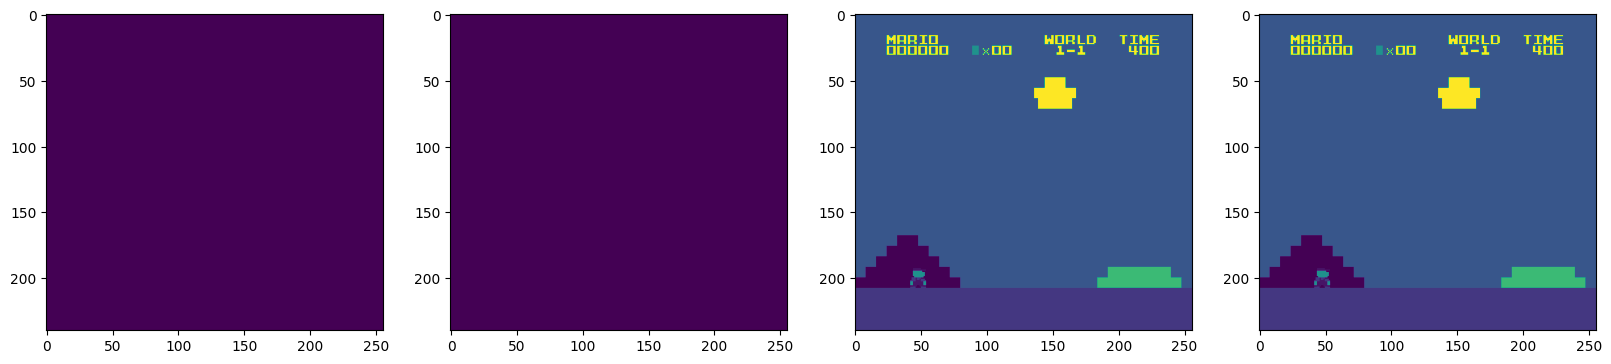

In [9]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# 3. Train the RL Model

In [11]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [12]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [12]:
CHECKPOINT_DIR = './train3/'
LOG_DIR = './logs3/'

In [13]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [14]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [19]:
# upgrade pip
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [16]:
#intsalling tensor flow (if OS error occurs, then you have to Enable NTFS long paths policy , link : https://superuser.com/questions/1119883/windows-10-enable-ntfs-long-paths-policy-option-missing)
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.16.0rc0-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.0rc0-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
Using cached tensorflow-2.16.0rc0-cp312-cp312-win_amd64.whl (2.1 kB)
Using cached tensorflow_intel-2.16.0rc0-cp312-cp312-win_amd64.whl (377.1 MB)


In [17]:
#Install TensorBoard for visualization
#!pip install torch torchvision (Make Sure you have installed it before running this command)
!pip install tensorboard

Defaulting to user installation because normal site-packages is not writeable


In [15]:
# Train the AI model, this is where the AI model starts to learn
#callback
#model.learn(total_timesteps=1000000, callback=callback)

#without callback
model.learn(total_timesteps=200000, callback=callback)

Logging to ./logs3/PPO_3
----------------------------
| time/              |     |
|    fps             | 66  |
|    iterations      | 1   |
|    time_elapsed    | 7   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 2           |
|    time_elapsed         | 30          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.035689387 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | -0.00564    |
|    learning_rate        | 0.0001      |
|    loss                 | 15.8        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00682    |
|    value_loss           | 238         |
-----------------------------------------
----------------

In [16]:
model.save('thisisatestmodel')

# 4. Test it Out

In [13]:
# Load model
model = PPO.load('./train3/best_model_100000')

In [14]:
state = env.reset()

In [15]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

C:\Users\MUSA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


KeyboardInterrupt: 

In [16]:
env.close()